In [1]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [2]:
from QuantumWalkModule.OneDimensionQW import *
import matplotlib.pyplot as plt

In [3]:
dim = 50
coin_conf = {
    "th" : np.pi/2
}
steps = 100

model = QW_1d(dim , coin_conf)
data = model.run(steps,state = "Gaussian")

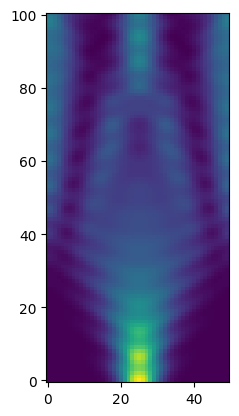

In [4]:
plt.imshow(data,origin = "lower")
plt.show()